# [RQ4]

In [17]:
from steam_analysis import languages_pie,\
                           count_languages,\
                           sort_count,\
                           print_top_languages,\
                           filter_by_language,\
                           compute_prob,\
                           format_prob

## Top Languages
First, we want to check in what languages most of the reviews are written in.

We can manage to load the whole dataset by only selecting the columns we will need for our analysis.

In [5]:
df = pd.read_csv("data/steam_reviews.csv", 
                 usecols = ['review_id', 'language', 'votes_funny', 'votes_helpful'], 
                 header = 'infer')

## What are the most common languages?

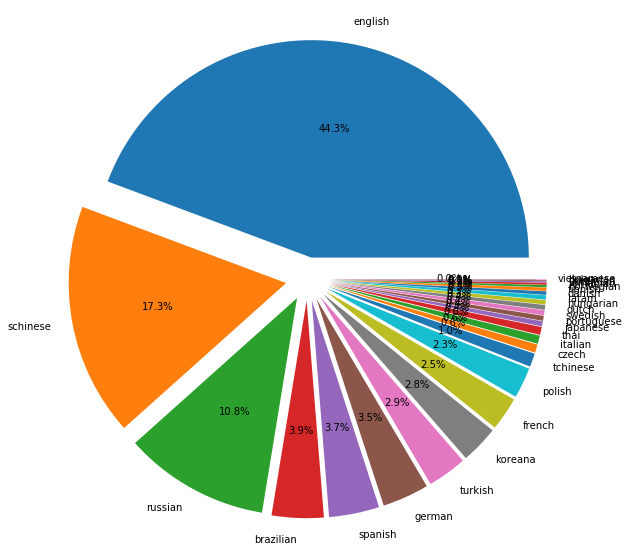

The three most common languages are:
English with 9635437 reviews
Schinese with 3764967 reviews
Russian with 2348900 reviews


In [6]:
languages_pie(df['language'])

top_languages = sort_count(count_languages(df))

print_top_languages(top_languages)

### Now let's filter the dataset so it only includes reviews in these languages

How did other users consider these reviews: 'Funny' or 'Helpful'?

In [18]:
filtered_df = filter_by_language(df, [language for language, _ in top_languages])

11% of the English reviews were considered 'Funny'
29% of the English reviews were considered 'Helpful'
12% of the Schinese reviews were considered 'Funny'
25% of the Schinese reviews were considered 'Helpful'
17% of the Russian reviews were considered 'Funny'
36% of the Russian reviews were considered 'Helpful'


Generally the reviews in Russian seem to attract more interactions **among these three languages**, as they were rated more often either 'Funny' or 'Helpful' than the English or Chinese ones, which were rated similarly. 

# [RQ5]

# [RQ6]

# [RQ7]

In [14]:
from steam_analysis import compute_prob, format_prob, norm_col
import seaborn as sns

sns.set()

Let's only import the columns we need, so we can keep memory usage to a minimum

In [6]:
df = pd.read_csv("data/steam_reviews.csv", 
                 usecols = ['review_id', 'votes_funny', 'weighted_vote_score'], 
                 header = 'infer')

## Weighted Vote Score

We want to know what's the probability of a review having a *WVS* of at least 0.5.

In order to do so, let's take a first look into how these scores are distributed.

In [7]:
df['weighted_vote_score'].describe()

count    2.174737e+07
mean     1.654424e-01
std      2.434006e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.827586e-01
max      9.959868e-01
Name: weighted_vote_score, dtype: float64

The distribution has a mean of about 0.16, and about 3/4 of the votes are below 0.5. 

This tells us that we should expect a low figure for $\mathcal{P}(score \geq 0.5)$

In order to get a better grasp of this data, we should plot an histogram of the values.

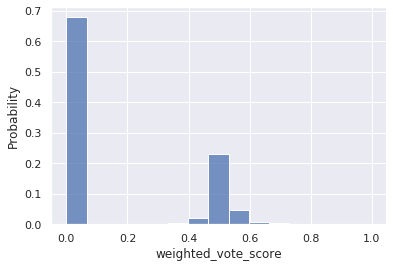

In [190]:
sns.histplot(df['weighted_vote_score'], bins = 15, stat = "probability")

The vast majority of reviews have a Weighted Vote Score of exactly 0, so instead on working with the entire dataset, let's only focus on those reviews which have a non-zero score.

In [188]:
wvs = df[df['weighted_vote_score'] > 0]

print(wvs['weighted_vote_score'].describe())

print("\nThe median is", wvs['weighted_vote_score'].median())

count    6.976357e+06
mean     5.157330e-01
std      6.343698e-02
min      8.186612e-03
25%      4.907975e-01
50%      5.215110e-01
75%      5.238096e-01
max      9.959868e-01
Name: weighted_vote_score, dtype: float64

The median is 0.5215110182762146


Only about 1/3 of the reviews have a non-zero score. The mean now is very close to 0.5 and the distribution is (probability-wise) symmetric about 0.52; as we can visualize from the updated histogram the scores seem normally distributed, although the right tail is heavier than the left one: reviews tend to have a score higher than 0.5 more likely than lower.

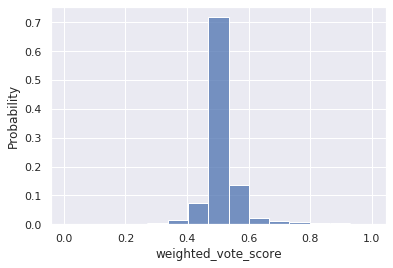

In [189]:
sns.histplot(wvs['weighted_vote_score'], bins = 15, stat = "probability")

To estimate the probability of $\mathcal{P}(score \geq 0.5)$ we can sum up the number of elements contained in each bin in the interval $[0.5, 1.0]$ and then divide the value we get by the total number of binned elements.

This is easily done by operating directly on the dataset.

In [22]:
prob_wvs = compute_prob(wvs, 'weighted_vote_score', 0.5)

print(format_prob(prob_wvs))

68.58%


About 2/3 of the reviews have a Weighted Vote Score of at least 0.5.

On the other hand, by considering the original dataset we would have gotten only about 1/5 of the reviews.

In [23]:
prob_wvs_orig = compute_prob(df, 'weighted_vote_score', 0.5)

print(format_prob(prob_wvs_orig))

22.00%


## Let's take a deeper look into these reviews

We want to study the correlation between a review having a *WVS* bigger than or equal to 0.5 and it being rated as 'Funny'.

First, let's compute the probability of a review having at least one 'Funny' vote given $WVS \geq 0.5$:

$\mathcal{P}(funny \geq 1\: |\: WVS \geq 0.5)$

We can filter the `wvs` dataframe with non-zero only *WVS's* so it only includes reviews with $WVS \geq 0.5$, and then compute the frequency (the *probability*) __among those__ of reviews that have at least one 'Funny' vote.

In [46]:
prob_wvs_funny = compute_prob(wvs[wvs['weighted_vote_score'] >= 0.5], 'votes_funny', 1)

print(format_prob(prob_wvs_funny))

24.91%


About 1/4 of those reviews have received at least one 'Funny' vote.

### Are these two events independent?

If the probability of a review having $WVS \geq 0.5$ and the probability of it having been rated as 'Funny' by at least one user are independent, then we expect

$\mathcal{P}(WVS \geq 0.5\: \text{and}\: funny \geq 1) = \mathcal{P}(WVS \geq 0.5)\cdot\mathcal{P}(funny \geq 1)$

i.e.

$\mathcal{P}(funny \geq 1\: |\: WVS \geq 0.5) = \frac{\mathcal{P}(WVS \geq 0.5\: \text{and}\: funny \geq 1)}{\mathcal{P}(WVS \geq 0.5)} = \mathcal{P}(funny \geq 1)$

In order to check if this equality holds, let's compute $\mathcal{P}(funny \geq 1)$.

We will filter these reviews out of the dataset which contains only reviews with non-zero *WVS*'s.

In [69]:
prob_funny = compute_prob(wvs, 'votes_funny', 1)

print(format_prob(prob_funny))

25.45%


If we evaluate

In [ ]:
print(format_prob(prob_wvs_funny / prob_funny))

We get a value which is quite close to 1, but not enough to say with reasonable certainty that the two are independent.

Let's plot them and see if we can actually spot any relationship between the *WVS* of a review and the number of 'Funny' votes it received.

We'll get this data by considering only rows of the `wvs` dataframe which have both $WVS\geq0.5$ and at least one 'Funny' vote, so we can actually compare values out of the same reviews.

**Remark:** for this analysis we will only consider reviews with at most 100 'Funny' votes because they are the vast majority and so we can exclude reviews with dubiously large amounts of votes.

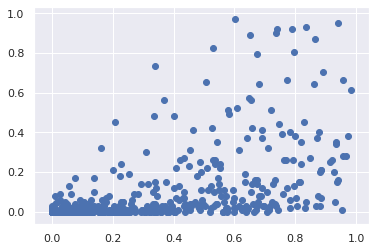

In [184]:
wvs_funny = wvs[(wvs['weighted_vote_score'] >= 0.5) 
                 & (wvs['votes_funny'] >= 1) 
                 & (wvs['votes_funny'] <= 100)]

# We normalize the values so they are between 0 and 1
wvs_norm = norm_col(wvs_funny['weighted_vote_score'])
funny_norm = norm_col(wvs_funny['votes_funny'])

plt.scatter(wvs_norm[:1000], funny_norm[:1000])

By plotting only the first 1000 values we can see *some* linear relationship.

If we compute the linear relationship of all filtered values we do in fact get a value of

In [183]:
print(wvs_norm.corr(funny_norm))

0.5161788195426803


which indicates the variables do have some correlation.

Hence we should be able to safely conclude that the two **are not** independent.